In [79]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import zscore
from scipy.stats import boxcox
import scipy.stats as stats

In [80]:
idx = 30

In [81]:
import sys
sys.path.append("..") 
sys.path.append("../..") 
import torch
from models.components.ldm.denoiser import UNetModel
import numpy as np
import torch.nn.functional as F
import json

import hydra
from LDM_conditional.DownscalingDataModule import DownscalingDataModule
from LDM_conditional.models.unet_module import DownscalingUnet
from LDM_conditional.models.ae_module import AutoencoderKL
from LDM_conditional.models.ldm_module import LatentDiffusion
from LDM_conditional.models.components.ldm.denoiser import DDIMSampler
from omegaconf import DictConfig
import paths

In [82]:
import seaborn as sns
sns.set() 
import matplotlib.pyplot as plt
import numpy as np

In [83]:
from models.unet_module import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.ldm_module import LatentDiffusion
from DownscalingDataModule import DownscalingDataModule

In [84]:
import torch
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.ae_module import AutoencoderKL
from models.unet_module import DownscalingUnetLightning
from models.components.ldm.denoiser import UNetModel
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.components.ldm.conditioner import AFNOConditionerNetCascade
from models.ldm_module import LatentDiffusion
import json
import paths

Dataloaders

In [85]:
# Define train and val input/target paths (update file paths as needed)
train_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_train_scaled.nc",
}
train_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_train_scaled.nc",

}
val_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_val_scaled.nc",

}
val_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_val_scaled.nc",

}

test_input_paths= {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_test_scaled.nc",

}

test_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_test_scaled.nc",

}


In [86]:
elevation_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [87]:
dm = DownscalingDataModule(
    train_input=train_input_paths,
    train_target=train_target_paths,
    val_input=val_input_paths,
    val_target=val_target_paths,
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)
dm.setup()


In [88]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [89]:
train_inputs, train_targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))
test_inputs, test_targets = next(iter(test_loader))

1. Plotting Unet pred for idex = idx

In [90]:
ckpt_unet = paths.LDM_DIR+"/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt"


In [91]:

model_UNet = DownscalingUnetLightning(
    in_ch=3,  # 4 vars + elevation
    out_ch=2,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"],
    
)

In [92]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu",weights_only=False)["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [93]:
with open(paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json", 'r') as f:
    pr_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TabsD_scaling_params.json", 'r') as f:
    temp_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
UNet_model = model_UNet.to(device)

#VAE encoding residuals 

In [96]:
encoder = SimpleConvEncoder(in_dim=2, levels=2, min_ch=16, ch_mult=4)
decoder = SimpleConvDecoder(in_dim=32, levels=2, min_ch=16, out_dim=2, ch_mult=4)  # use 16 if your latent_dim is 16


normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}


In [97]:
unet_regr= DownscalingUnetLightning(in_ch=3,
                                    out_ch=2,
                                    features=[64, 128, 256, 512],
                                    channel_names=["precip", "temp"])

In [98]:
unet_regr_ckpt = torch.load("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
                            map_location="cpu",
weights_only=False)["state_dict"]

In [99]:
unet_regr.load_state_dict(unet_regr_ckpt, strict=False) #Loading it second time for regression network inside VAE
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

Instantiating VAE

In [100]:
vae_model = AutoencoderKL(
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.01,
    latent_dim=16,
    ae_flag="residual",
    unet_regr=unet_regr
)

Loading LDM ckp

In [101]:
import torch
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.ae_module import AutoencoderKL
from models.unet_module import DownscalingUnetLightning
from models.components.ldm.denoiser import UNetModel
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.components.ldm.conditioner import AFNOConditionerNetCascade
from models.ldm_module import LatentDiffusion
import json
import paths

Inspecting ckps

In [102]:
import torch

vae_ckpt_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/VAE_ckpts/VAE_levels_latentdim_16_klweight_0.001_checkpoint.ckpt"
vae_ckpt = torch.load(vae_ckpt_path, map_location="cpu")
print("VAE checkpoint keys:", vae_ckpt.keys())
vae_state = vae_ckpt["state_dict"] if "state_dict" in vae_ckpt else vae_ckpt
print("\nVAE state_dict parameter shapes:")
for k, v in vae_state.items():
    print(f"{k}: {tuple(v.shape)}")


VAE checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

VAE state_dict parameter shapes:
bias: (1, 2, 1, 1)
encoder.net.0.proj.weight: (16, 2, 1, 1)
encoder.net.0.proj.bias: (16,)
encoder.net.0.conv1.weight: (16, 2, 3, 3)
encoder.net.0.conv1.bias: (16,)
encoder.net.0.conv2.weight: (16, 16, 3, 3)
encoder.net.0.conv2.bias: (16,)
encoder.net.0.norm1.weight: (2,)
encoder.net.0.norm1.bias: (2,)
encoder.net.0.norm2.weight: (16,)
encoder.net.0.norm2.bias: (16,)
encoder.net.0.sequence.0.weight: (2,)
encoder.net.0.sequence.0.bias: (2,)
encoder.net.0.sequence.2.weight: (16, 2, 3, 3)
encoder.net.0.sequence.2.bias: (16,)
encoder.net.0.sequence.3.weight: (16,)
encoder.net.0.sequence.3.bias: (16,)
encoder.net.0.sequence.5.weight: (16, 16, 3, 3)
encoder.net.0.sequence.5.bias: (16,)
encoder.net.1.weight: (16, 16, 2, 2)
encoder.net.1.bias: (16,)
encoder.net.2.proj.weight: (32, 16, 1, 1)
encoder.net.2

In [103]:
ldm_ckpt_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts/12km/LDM/LDM_checkpoint_model.parameterization=0_model.timesteps=0_model.noise_schedule=0.ckpt"
ldm_ckpt = torch.load(ldm_ckpt_path, map_location="cpu")
print("\nLDM checkpoint keys:", ldm_ckpt.keys())
ldm_state = ldm_ckpt["state_dict"] if "state_dict" in ldm_ckpt else ldm_ckpt
print("\nLDM state_dict parameter shapes:")
for k, v in ldm_state.items():
    print(f"{k}: {tuple(v.shape)}")


LDM checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

LDM state_dict parameter shapes:
betas: (500,)
alphas_cumprod: (500,)
alphas_cumprod_prev: (500,)
sqrt_alphas_cumprod: (500,)
sqrt_one_minus_alphas_cumprod: (500,)
denoiser.time_embed.0.weight: (256, 64)
denoiser.time_embed.0.bias: (256,)
denoiser.time_embed.2.weight: (256, 256)
denoiser.time_embed.2.bias: (256,)
denoiser.input_blocks.0.0.weight: (64, 16, 3, 3)
denoiser.input_blocks.0.0.bias: (64,)
denoiser.input_blocks.1.0.in_layers.2.weight: (64, 64, 3, 3)
denoiser.input_blocks.1.0.in_layers.2.bias: (64,)
denoiser.input_blocks.1.0.emb_layers.1.weight: (64, 256)
denoiser.input_blocks.1.0.emb_layers.1.bias: (64,)
denoiser.input_blocks.1.0.out_layers.3.weight: (64, 64, 3, 3)
denoiser.input_blocks.1.0.out_layers.3.bias: (64,)
denoiser.input_blocks.1.1.pre_proj.weight: (128, 128)
denoiser.input_blocks.1.1.pre_proj.bias: (128,)
den

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_regr = DownscalingUnetLightning(
    in_ch=3,
    out_ch=2,
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"]
)
unet_regr_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
    map_location="cpu",weights_only=False
)["state_dict"]
unet_regr.load_state_dict(unet_regr_ckpt, strict=False)
unet_regr = unet_regr.to(device)
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [105]:
encoder = SimpleConvEncoder(in_dim=2, levels=2, min_ch=16, ch_mult=4)
decoder = SimpleConvDecoder(in_dim=16, levels=2, min_ch=16, out_dim=2, ch_mult=4)

#Latent dim has to be explicity set!!!! NPOTE : AsthanaSh
vae_model = AutoencoderKL(
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.001,  
    ae_flag="residual",
    unet_regr=unet_regr,
    latent_dim=16
)
vae_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/VAE_ckpts/VAE_levels_latentdim_16_klweight_0.001_checkpoint.ckpt",
    map_location="cpu"
)["state_dict"]
vae_model.load_state_dict(vae_ckpt, strict=False)
vae_model = vae_model.to(device)
vae_model.eval()

normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}


AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 2, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 16, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 2, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 16, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
      (2): ResBlock2D(
        (proj): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))


In [106]:
denoiser = UNetModel(
    model_channels=64,
    in_channels=16,
    out_channels=16,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=[64, 128, 256, 256],
    channel_mult=[1, 2, 4, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=4
)

conditioner = AFNOConditionerNetCascade(
    autoencoder=vae_model,
    embed_dim=[64, 128, 256, 256],
    analysis_depth=4,
    cascade_depth=4,
    context_ch=[64, 128, 256, 256]
)

ldm = LatentDiffusion(
    denoiser=denoiser,
    autoencoder=vae_model,
    context_encoder=conditioner,
    timesteps=500,
    parameterization="v",
    loss_type="l2"
)
ldm_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts/12km/LDM/LDM_checkpoint_model.parameterization=0_model.timesteps=0_model.noise_schedule=0.ckpt",
    map_location=device
)
ldm.load_state_dict(ldm_ckpt["state_dict"], strict=False)
ldm = ldm.to(device)
ldm.eval()



normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 8}


LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

In [107]:
sampler = DDIMSampler(ldm, device=device)


In [108]:
unet_regr.precip_epsilon = pr_params.get('epsilon', 0.05)
unet_regr.precip_mean = pr_params['mean']
unet_regr.precip_std = pr_params['std']
unet_regr.precip_channel_idx = 0  


In [109]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)   # (1, 5, H, W)
    unet_pred = unet_regr(input_sample)                       # (1, 2, H, W)
    latent_shape = (1, 16, unet_pred.shape[2] // 4, unet_pred.shape[3] // 4)
    z = torch.randn(latent_shape, device=device)
    context = conditioner([(unet_pred, None)])

    sampled_latent, _ = sampler.sample(
        S=250,
        batch_size=1,
        shape=latent_shape[1:],
        conditioning=[(unet_pred, None)],
        eta=0.0,
        verbose=True,
        x_T=z,
    )
    generated_residual = vae_model.decode(sampled_latent)

    if generated_residual.shape != unet_pred.shape:
        _, _, h1, w1 = unet_pred.shape
        _, _, h2, w2 = generated_residual.shape
        crop_h = min(h1, h2)
        crop_w = min(w1, w2)
        start_h = (h2 - crop_h) // 2
        start_w = (w2 - crop_w) // 2
        generated_residual = generated_residual[:, :, start_h:start_h+crop_h, start_w:start_w+crop_w]
        if h1 != crop_h or w1 != crop_w:
            start_h_u = (h1 - crop_h) // 2
            start_w_u = (w1 - crop_w) // 2
            unet_pred = unet_pred[:, :, start_h_u:start_h_u+crop_h, start_w_u:start_w_u+crop_w]
    final_pred = unet_pred + generated_residual

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
Selected timesteps for ddim sampler: [  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215
 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251
 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283 285 287
 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323
 325 327 329 331 333 335 337

DDIM Sampler:   0%|          | 0/250 [00:00<?, ?it/s]

DDIM Sampler:   1%|          | 3/250 [00:00<00:10, 22.65it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   4%|▎         | 9/250 [00:00<00:10, 22.83it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:   5%|▍         | 12/250 [00:00<00:10, 22.76it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:   7%|▋         | 18/250 [00:00<00:10, 22.83it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   8%|▊         | 21/250 [00:00<00:10, 22.81it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  11%|█         | 27/250 [00:01<00:09, 22.83it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  12%|█▏        | 30/250 [00:01<00:09, 22.82it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  14%|█▍        | 36/250 [00:01<00:09, 22.84it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  16%|█▌        | 39/250 [00:01<00:09, 22.79it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  18%|█▊        | 45/250 [00:01<00:08, 22.82it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  19%|█▉        | 48/250 [00:02<00:09, 21.41it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  22%|██▏       | 54/250 [00:02<00:08, 21.95it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  23%|██▎       | 57/250 [00:02<00:08, 22.19it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  25%|██▌       | 63/250 [00:02<00:08, 22.57it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  26%|██▋       | 66/250 [00:02<00:08, 22.70it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  28%|██▊       | 69/250 [00:03<00:08, 22.51it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:  29%|██▉       | 72/250 [00:03<00:07, 22.68it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  30%|███       | 75/250 [00:03<00:07, 22.71it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  31%|███       | 78/250 [00:03<00:07, 22.57it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])


DDIM Sampler:  32%|███▏      | 81/250 [00:03<00:07, 22.59it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  35%|███▍      | 87/250 [00:03<00:07, 22.79it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  36%|███▌      | 90/250 [00:03<00:07, 22.80it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  38%|███▊      | 96/250 [00:04<00:06, 22.75it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  40%|███▉      | 99/250 [00:04<00:06, 22.69it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  42%|████▏     | 105/250 [00:04<00:06, 22.67it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 1

DDIM Sampler:  43%|████▎     | 108/250 [00:04<00:06, 22.68it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  46%|████▌     | 114/250 [00:05<00:06, 22.51it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  47%|████▋     | 117/250 [00:05<00:05, 22.48it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  48%|████▊     | 120/250 [00:05<00:05, 22.56it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  49%|████▉     | 123/250 [00:05<00:05, 22.67it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  50%|█████     | 126/250 [00:05<00:05, 22.68it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  52%|█████▏    | 129/250 [00:05<00:05, 22.71it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  53%|█████▎    | 132/250 [00:05<00:05, 22.74it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  54%|█████▍    | 135/250 [00:05<00:05, 22.69it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  55%|█████▌    | 138/250 [00:06<00:04, 22.68it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  56%|█████▋    | 141/250 [00:06<00:04, 22.30it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape afte

DDIM Sampler:  58%|█████▊    | 144/250 [00:06<00:04, 22.14it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  59%|█████▉    | 147/250 [00:06<00:04, 22.00it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 1

DDIM Sampler:  60%|██████    | 150/250 [00:06<00:04, 22.22it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  61%|██████    | 153/250 [00:06<00:04, 22.20it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  62%|██████▏   | 156/250 [00:06<00:04, 22.40it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  64%|██████▎   | 159/250 [00:07<00:04, 22.51it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  66%|██████▌   | 165/250 [00:07<00:03, 22.63it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  67%|██████▋   | 168/250 [00:07<00:03, 22.67it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  70%|██████▉   | 174/250 [00:07<00:03, 22.65it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  71%|███████   | 177/250 [00:07<00:03, 22.62it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  73%|███████▎  | 183/250 [00:08<00:02, 22.71it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  74%|███████▍  | 186/250 [00:08<00:02, 22.66it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  76%|███████▌  | 189/250 [00:08<00:02, 22.73it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  77%|███████▋  | 192/250 [00:08<00:02, 22.78it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  78%|███████▊  | 195/250 [00:08<00:02, 22.80it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  79%|███████▉  | 198/250 [00:08<00:02, 22.81it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  80%|████████  | 201/250 [00:08<00:02, 22.82it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  82%|████████▏ | 204/250 [00:09<00:02, 22.68it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  83%|████████▎ | 207/250 [00:09<00:01, 22.73it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  84%|████████▍ | 210/250 [00:09<00:01, 22.72it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  85%|████████▌ | 213/250 [00:09<00:01, 22.63it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  86%|████████▋ | 216/250 [00:09<00:01, 22.64it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  88%|████████▊ | 219/250 [00:09<00:01, 22.73it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  90%|█████████ | 225/250 [00:09<00:01, 22.70it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  91%|█████████ | 228/250 [00:10<00:00, 22.73it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  94%|█████████▎| 234/250 [00:10<00:00, 22.72it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  95%|█████████▍| 237/250 [00:10<00:00, 22.68it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  97%|█████████▋| 243/250 [00:10<00:00, 22.78it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  98%|█████████▊| 246/250 [00:10<00:00, 22.81it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 16, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler: 100%|█████████▉| 249/250 [00:11<00:00, 22.87it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler: 100%|██████████| 250/250 [00:11<00:00, 22.62it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

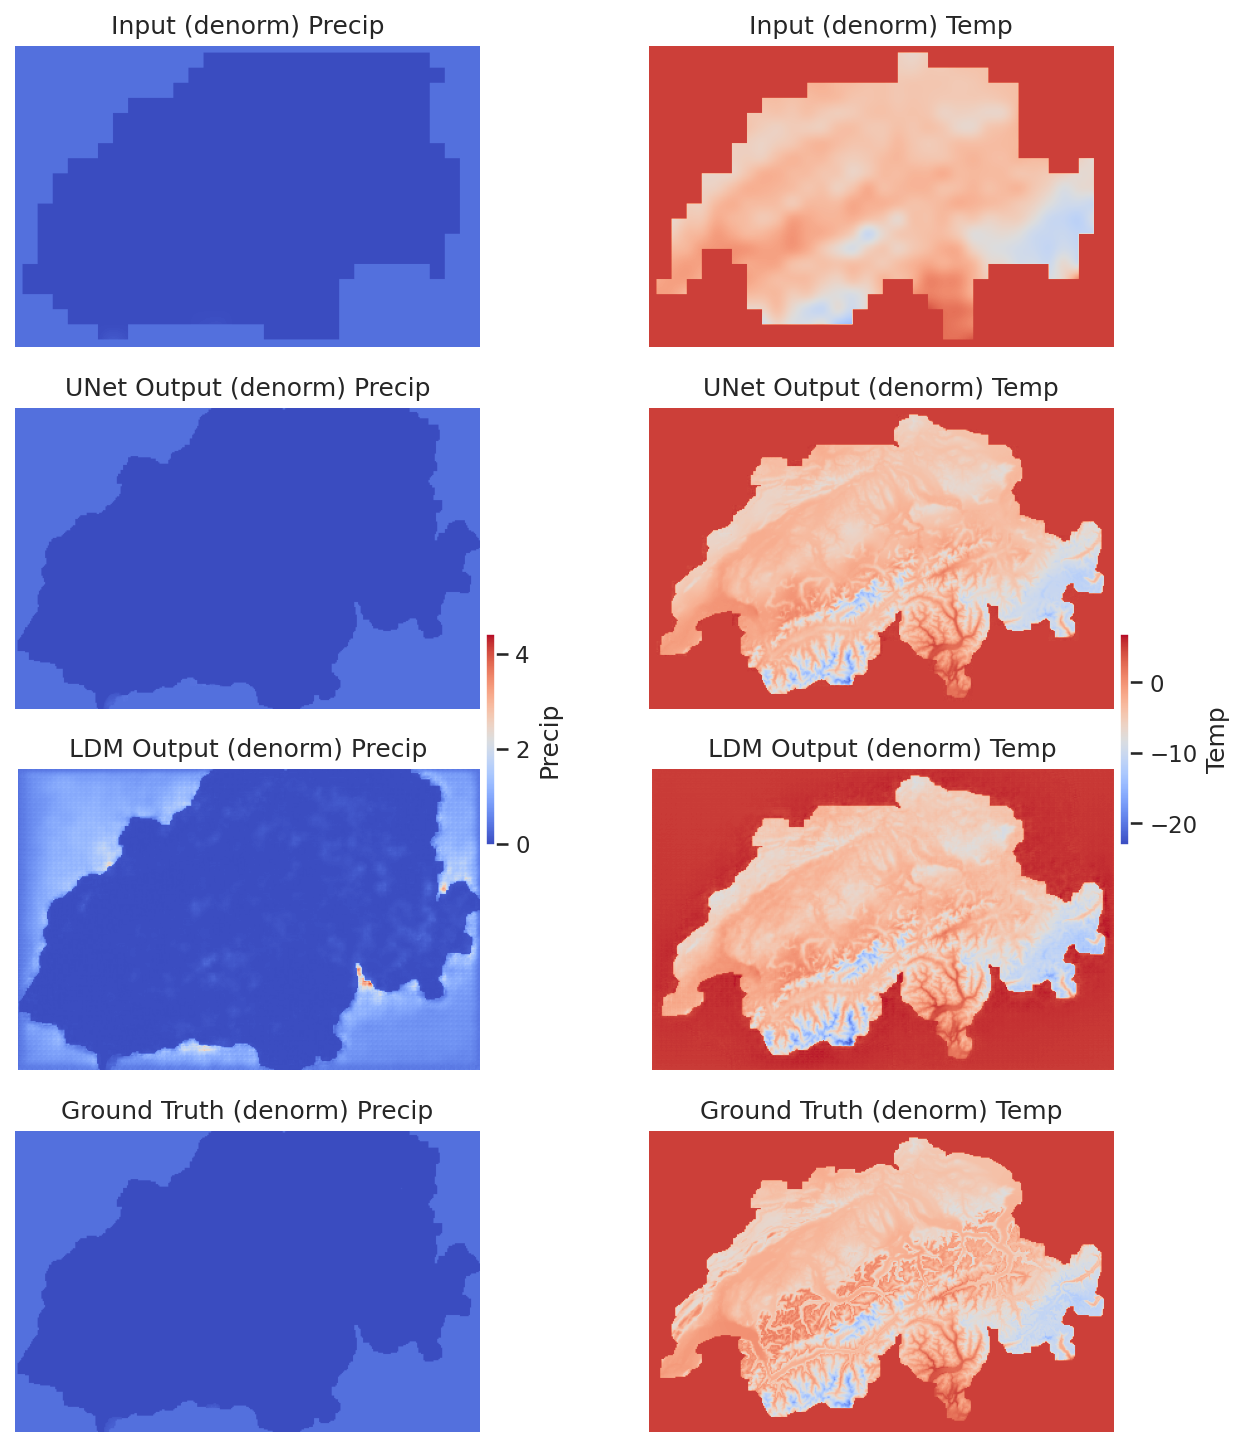

In [110]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)  # (1, C_in, H, W)
    unet_pred = unet_regr(input_sample)                      # (1, C_out, H, W)
    final_pred_np = final_pred[0].cpu().numpy()              # (C_out, H, W)
    unet_pred_np = unet_pred[0].cpu().numpy()                # (C_out, H, W)
    input_np = input_sample[0, :unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)
    target_np = test_targets[idx][:unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)

    channel_names = ["Precip", "Temp"]
    params_list = [pr_params, temp_params]

    input_denorm = np.empty_like(input_np)
    for i, params in enumerate(params_list):
        if i == 0:  # Precip
            input_denorm[i] = denorm_pr(input_np[i])
        else:
            input_denorm[i] = denorm_temp(input_np[i], params)

    unet_pred_denorm = np.empty_like(unet_pred_np)
    for i, params in enumerate(params_list):
        if i == 0:
            unet_pred_denorm[i] = denorm_pr(unet_pred_np[i])
        else:
            unet_pred_denorm[i] = denorm_temp(unet_pred_np[i], params)

    ldm_pred_denorm = np.empty_like(final_pred_np)
    for i, params in enumerate(params_list):
        if i == 0:
            ldm_pred_denorm[i] = denorm_pr(final_pred_np[i])
        else:
            ldm_pred_denorm[i] = denorm_temp(final_pred_np[i], params)

    target_denorm = np.empty_like(target_np)
    for i, params in enumerate(params_list):
        if i == 0:
            target_denorm[i] = denorm_pr(target_np[i])
        else:
            target_denorm[i] = denorm_temp(target_np[i], params)

    vmins = [min(input_denorm[j].min(), unet_pred_denorm[j].min(), ldm_pred_denorm[j].min(), target_denorm[j].min()) for j in range(len(params_list))]
    vmaxs = [max(input_denorm[j].max(), unet_pred_denorm[j].max(), ldm_pred_denorm[j].max(), target_denorm[j].max()) for j in range(len(params_list))]

    fig, axes = plt.subplots(4, len(params_list), figsize=(5*len(params_list), 12), dpi=150)
    if len(params_list) == 1:
        axes = axes[:, np.newaxis]
    for j in range(len(params_list)):
        axes[0, j].imshow(np.flipud(input_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[0, j].set_title(f"Input (denorm) {channel_names[j]}")
        axes[0, j].axis('off')
        axes[1, j].imshow(np.flipud(unet_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[1, j].set_title(f"UNet Output (denorm) {channel_names[j]}")
        axes[1, j].axis('off')
        axes[2, j].imshow(np.flipud(ldm_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[2, j].set_title(f"LDM Output (denorm) {channel_names[j]}")
        axes[2, j].axis('off')
        axes[3, j].imshow(np.flipud(target_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[3, j].set_title(f"Ground Truth (denorm) {channel_names[j]}")
        axes[3, j].axis('off')
        cbar = fig.colorbar(axes[0, j].images[0], ax=axes[:, j], fraction=0.02, pad=0.01)
        cbar.ax.set_ylabel(channel_names[j])

    plt.show()